In [1]:
import numpy as np
import random
import json
import csv

from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras import optimizers
from livelossplot import PlotLossesKeras
from keras_sequential_ascii import keras2ascii
import os
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

Using TensorFlow backend.


In [2]:
import seaborn as sn
sn.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (20,10)
plt.rcParams.update({'font.size': 12})

In [3]:
np.random.seed(43)

In [4]:
TRAIN_DIR = '../dogs-vs-cats/train/'
TEST_DIR = '../dogs-vs-cats/test1/'

ROWS = 150
COLS = 150
CHANNELS = 3

BATCH_SIZE=128

In [5]:
original_train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
random.shuffle(original_train_images)
train_images = original_train_images[:17500]
validation_images = original_train_images[17500:22000]
test_images = original_train_images[22000:]

In [6]:
def prep_data(images):
    count = len(images)
    X = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.float32)
    y = np.zeros((count,), dtype=np.float32)
    
    for i, image_file in enumerate(images):
        img = image.load_img(image_file, target_size=(ROWS, COLS))
        X[i] = image.img_to_array(img)/255
        if 'dog' in image_file.split('/dogs-vs-cats/')[1]:
            y[i] = 1.
        if i%1000 == 0: print('Processed {} of {}'.format(i, count))
    
    return X, y

In [7]:
X_train, y_train = prep_data(train_images)

Processed 0 of 17500
Processed 1000 of 17500
Processed 2000 of 17500
Processed 3000 of 17500
Processed 4000 of 17500
Processed 5000 of 17500
Processed 6000 of 17500
Processed 7000 of 17500
Processed 8000 of 17500
Processed 9000 of 17500
Processed 10000 of 17500
Processed 11000 of 17500
Processed 12000 of 17500
Processed 13000 of 17500
Processed 14000 of 17500
Processed 15000 of 17500
Processed 16000 of 17500
Processed 17000 of 17500


In [8]:
X_validation, y_validation = prep_data(validation_images)

Processed 0 of 4500
Processed 1000 of 4500
Processed 2000 of 4500
Processed 3000 of 4500
Processed 4000 of 4500


In [9]:
X_test, y_test = prep_data(test_images)

Processed 0 of 3000
Processed 1000 of 3000
Processed 2000 of 3000


In [10]:
print('Train: ',X_train.shape, y_train.shape)
print('Validation: ', X_validation.shape, y_validation.shape)
print('Test: ', X_test.shape, y_test.shape)

Train:  (17500, 150, 150, 3) (17500,)
Validation:  (4500, 150, 150, 3) (4500,)
Test:  (3000, 150, 150, 3) (3000,)


In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(ROWS, COLS, CHANNELS)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['accuracy'])
keras2ascii(model)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 33, 128)       73856     
______________________

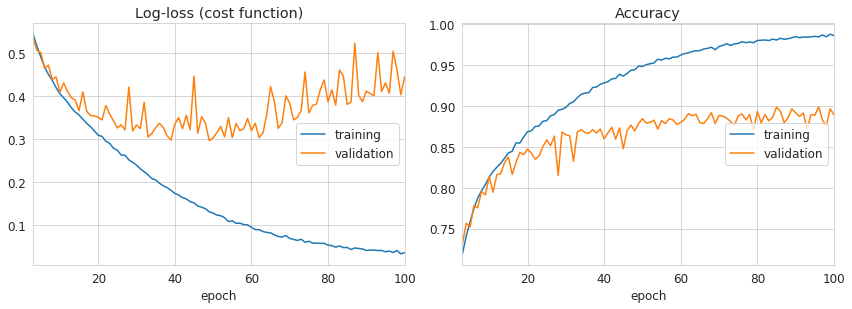

Log-loss (cost function):
training   (min:    0.034, max:    0.661, cur:    0.037)
validation (min:    0.297, max:    0.644, cur:    0.445)

Accuracy:
training   (min:    0.595, max:    0.988, cur:    0.986)
validation (min:    0.596, max:    0.899, cur:    0.889)


In [12]:
train_steps = len(train_images)/BATCH_SIZE
validation_steps = len(validation_images)/BATCH_SIZE
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_validation, y_validation),
                    callbacks=[PlotLossesKeras()],
                    verbose=2)

In [13]:
y_pred = model.predict_classes(X_test)
evaluation1 = model.evaluate(X_test, y_test)
acc1 = accuracy_score(y_test, y_pred)
f1_1 = f1_score(y_test, y_pred, average='weighted')
print(evaluation1)
print('Accuracy: ', acc1)
print('F1 score: ', f1_1)
!telegram-send 'Model 1: Eval: {evaluation1} Acc: {acc1} F1: {f1_1}'

3000/3000 [==============================] - 13s 4ms/step
[0.42147476291656494, 0.891666666507721]
Accuracy:  0.8916666666666667
F1 score:  0.8916225269318286


In [14]:
train_datagen = image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

validation_datagen = image.ImageDataGenerator()

In [15]:
train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=BATCH_SIZE)

validation_generator = validation_datagen.flow(
    X_validation,
    y_validation,
    batch_size=BATCH_SIZE)

In [16]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(ROWS, COLS, CHANNELS)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
keras2ascii(model)
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 33, 33, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 128)       0         
__________

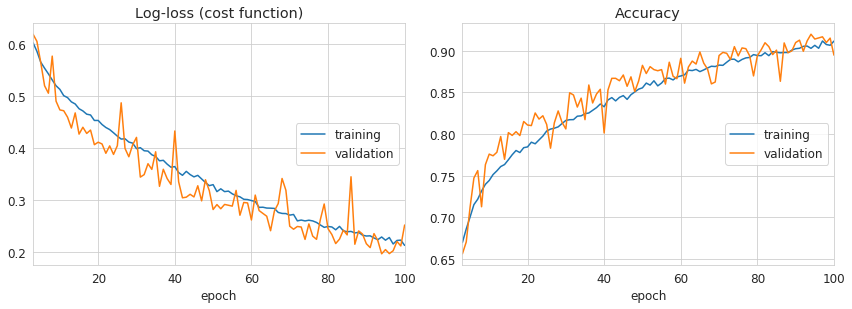

Log-loss (cost function):
training   (min:    0.214, max:    0.680, cur:    0.214)
validation (min:    0.197, max:    0.654, cur:    0.253)

Accuracy:
training   (min:    0.561, max:    0.912, cur:    0.912)
validation (min:    0.598, max:    0.920, cur:    0.895)


In [17]:
train_steps = len(train_images)/BATCH_SIZE
validation_steps = len(validation_images)/BATCH_SIZE

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[PlotLossesKeras()],
    verbose=2)

In [18]:
y_pred = model.predict_classes(X_test)
evaluation2 = model.evaluate(X_test, y_test)
acc2 = accuracy_score(y_test, y_pred)
f1_2 = f1_score(y_test, y_pred, average='weighted')
print(evaluation2)
print('Accuracy: ', acc2)
print('F1 score: ', f1_2)
!telegram-send 'Model 2: Eval: {evaluation2} Acc: {acc2} F1: {f1_2}'

3000/3000 [==============================] - 11s 4ms/step
[0.245685743590196, 0.905]
Accuracy:  0.905
F1 score:  0.9047909673179647


In [19]:
from keras.applications import InceptionV3

In [20]:
base_model = InceptionV3(include_top = False, weights = 'imagenet', input_shape = (ROWS, COLS, CHANNELS))

In [21]:
model = Sequential()
model.add(base_model)
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',  
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])
model.summary()
keras2ascii(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 26,521,889
Trainable params: 26,487,457
Non-trainable params: 34,432
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
___________________________________________________________

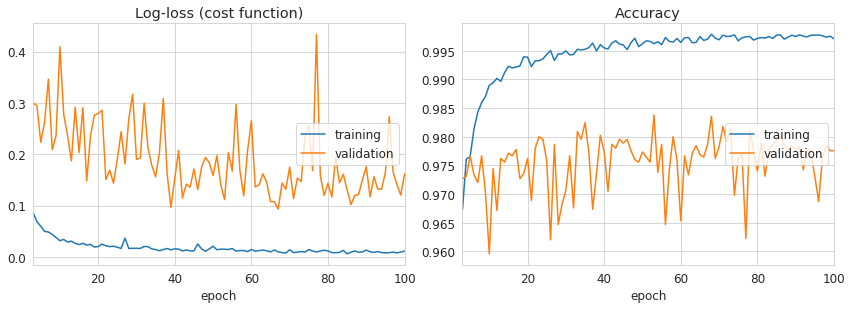

Log-loss (cost function):
training   (min:    0.006, max:    0.277, cur:    0.011)
validation (min:    0.093, max:    0.434, cur:    0.162)

Accuracy:
training   (min:    0.892, max:    0.998, cur:    0.997)
validation (min:    0.960, max:    0.984, cur:    0.978)


In [22]:
train_steps = len(train_images)/BATCH_SIZE
validation_steps = len(validation_images)/BATCH_SIZE

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[PlotLossesKeras()],
    verbose=2)

In [23]:
y_pred = model.predict_classes(X_test)
evaluation3 = model.evaluate(X_test, y_test)
acc3 = accuracy_score(y_test, y_pred)
f1_3 = f1_score(y_test, y_pred, average='weighted')
print(evaluation3)
print('Accuracy: ', acc3)
print('F1 score: ', f1_3)
!telegram-send 'Model 3: Eval: {evaluation3} Acc: {acc3} F1: {f1_3}'

3000/3000 [==============================] - 58s 19ms/step
[0.15614243963162078, 0.9776666666666667]
Accuracy:  0.9776666666666667
F1 score:  0.9776606984139412
